In [1]:
import numpy as np
from copy import deepcopy

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import DataLoader
from torch.autograd import Function

/home/hhchung/dyngraph-uda/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from sklearn.metrics import f1_score

In [4]:
from dataset import load_nc_dataset

In [5]:
import matplotlib.pyplot as plt

## Model Structure ##

In [6]:
class TwoLayerGraphSAGE(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.2):
        super().__init__()
        self.dropout = dropout
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout)
        
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        return x
    
class MLPHead(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.2):
        super().__init__()
        self.dropout = dropout
        self.linear1 = nn.Linear(in_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout)
        x = self.linear2(x)
        x = F.softmax(x, dim=1)
        return x

class DomainClassifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.2):
        super().__init__()
        self.dropout = dropout
        self.linear1 = nn.Linear(in_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout)
        x = self.linear2(x)
        x = F.softmax(x, dim=1)
        return x
    
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

## Data Preparation ##

* Train: 0-6
* Val: 7, 8
* Test and adapt: 9-13, 14-18, 19-23, 24-28, 29-33, 34-38, 39-43, 44-48

In [6]:
def get_data(data_dir, dataset, sub_dataset=None):
    if dataset == 'elliptic':
        data = load_nc_dataset(data_dir, 'elliptic', sub_dataset)
    else:
        raise ValueError('Invalid dataname')
    # if len(data.y.shape) == 1:
    #     data.y = data.y.unsqueeze(1)
    return data

In [7]:
data_dir = '/home/hhchung/data/graph-data/elliptic_bitcoin_dataset'

## Train / Test / Adapt Loop ##

In [8]:
data = get_data(data_dir, 'elliptic', 0)

/home/hhchung/dyngraph-uda/elliptic/dataset.py:75: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  edge_index = torch.tensor(A.nonzero(), dtype=torch.long)


In [9]:
def train(encoder, mlp, optimizer, loader, loss_fn, device='cpu'):
    encoder.train()
    mlp.train()
    optimizer.zero_grad()
    
    total_train_loss = 0
    for data in loader:
        data = data.to(device)
        out = mlp(encoder(data.x, data.edge_index))
        loss = loss_fn(out[data.mask], data.y[data.mask])
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    total_train_loss /= len(loader)
    return total_train_loss

def adapt(encoder, mlp, domain_classifier, reverse_layer, optimizer, src_loader, tgt_loader, e, epochs, loss_fn_class, loss_fn_domain, device='cpu'):
    encoder.train()
    # mlp.train()
    mlp.eval()
    for param in mlp.parameters():
        param.requires_grad = False
    domain_classifier.train()
    
    
    len_dataloader = min(len(src_loader), len(tgt_loader))
    src_iter = iter(src_loader)
    tgt_iter = iter(tgt_loader)
    
    # total_train_loss = 0
    total_src_label_loss = 0
    total_src_domain_loss = 0
    total_tgt_domain_loss = 0
    for i in range(len_dataloader):
        p = float(i + e * len_dataloader) / epochs / len_dataloader
        alpha = 2. / (1. + np.exp(-10 * p)) - 1
        
        src_data = src_iter.next().to(device)
        
        optimizer.zero_grad()
        src_batch_size = src_data.x.shape[0]
        # print("source batch size", batch_size)
        domain_label = torch.zeros(src_batch_size).long().to(device)
        
        feature = encoder(src_data.x, src_data.edge_index)
        class_output = mlp(feature)
        domain_output = domain_classifier(ReverseLayerF.apply(feature, alpha))
        
        
        loss_src_label = loss_fn_class(class_output[src_data.mask], src_data.y[src_data.mask])
        loss_src_domain = loss_fn_domain(domain_output, domain_label)
        

        tgt_data = tgt_iter.next().to(device)
        tgt_batch_size = tgt_data.x.shape[0]
        # print("target batch size", batch_size)
        domain_label = torch.ones(tgt_batch_size).long().to(device)
        
        domain_output = domain_classifier(ReverseLayerF.apply(encoder(tgt_data.x, tgt_data.edge_index), alpha))
        loss_tgt_domain = loss_fn_domain(domain_output, domain_label)
        
        total_batch_size = src_batch_size + tgt_batch_size
        loss = loss_src_label + loss_src_domain + loss_tgt_domain
        loss.backward()
        optimizer.step()
        
        # total_train_loss += loss.item()
        total_src_label_loss += loss_src_label.item()
        total_src_domain_loss += loss_src_domain.item()
        total_tgt_domain_loss += loss_tgt_domain.item()
    
    # total_train_loss /= len_dataloader
    total_src_label_loss /= len_dataloader
    total_src_domain_loss /= len_dataloader
    total_tgt_domain_loss /= len_dataloader
    
    return total_src_label_loss, total_src_domain_loss, total_tgt_domain_loss
        

@torch.no_grad()
def test(encoder, mlp, loader, loss_fn, device='cpu'):
    encoder.eval()
    mlp.eval()
    total_val_loss = 0
    total_f1 = 0
    for data in loader:
        data = data.to(device)
        out = mlp(encoder(data.x, data.edge_index))
        loss = loss_fn(out[data.mask], data.y[data.mask])
        y_pred = torch.argmax(out, dim=1)
        f1 = f1_score(y_pred[data.mask].detach().cpu().numpy(), data.y[data.mask].detach().cpu().numpy())
        total_val_loss += loss.item()
        total_f1 += f1
    total_val_loss /= len(loader)
    total_f1 /= len(loader)
    return total_val_loss, total_f1

## Initial Source Stage ##

In [10]:
elliptic_0 = get_data(data_dir, 'elliptic', 0)
feat_dim = elliptic_0.x.shape[1]
hidden_dim = 128
emb_dim = 128
encoder = TwoLayerGraphSAGE(feat_dim, hidden_dim, emb_dim)
mlp = MLPHead(emb_dim, emb_dim // 4, 2)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(mlp.parameters()), lr=1e-3)
epochs = 500
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = encoder.to(device)
mlp = mlp.to(device)

/home/hhchung/dyngraph-uda/elliptic/dataset.py:75: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  edge_index = torch.tensor(A.nonzero(), dtype=torch.long)


In [11]:
split = [0,7,9]
train_data = [get_data(data_dir, 'elliptic', i) for i in range(split[0],split[1])]
val_data = [get_data(data_dir, 'elliptic', i) for i in range(split[1],split[2])]
train_loader = DataLoader(dataset=train_data, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=1, shuffle=False)

In [12]:
best_f1 = 0
best_encoder = None
best_mlp = None
for e in range(1, epochs + 1):
    train_loss = train(encoder, mlp, optimizer, train_loader, loss_fn, device)
    val_loss, val_f1 = test(encoder, mlp, val_loader, loss_fn, device)
    print(f"Epoch:{e}/{epochs} Train Loss:{round(train_loss,4)} Val Loss:{round(val_loss,4)} Val F1:{round(val_f1, 4)}")
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_encoder = deepcopy(encoder)
        best_mlp = deepcopy(mlp)

encoder = deepcopy(best_encoder)
mlp = deepcopy(best_mlp)

Epoch:1/500 Train Loss:0.5438 Val Loss:0.566 Val F1:0.0079
Epoch:2/500 Train Loss:0.378 Val Loss:0.5199 Val F1:0.004
Epoch:3/500 Train Loss:0.3441 Val Loss:0.5082 Val F1:0.004
Epoch:4/500 Train Loss:0.3377 Val Loss:0.5067 Val F1:0.0
Epoch:5/500 Train Loss:0.3361 Val Loss:0.5068 Val F1:0.0
Epoch:6/500 Train Loss:0.3356 Val Loss:0.505 Val F1:0.0
Epoch:7/500 Train Loss:0.3354 Val Loss:0.5028 Val F1:0.0
Epoch:8/500 Train Loss:0.3352 Val Loss:0.5024 Val F1:0.0
Epoch:9/500 Train Loss:0.3351 Val Loss:0.5017 Val F1:0.0
Epoch:10/500 Train Loss:0.3349 Val Loss:0.5017 Val F1:0.0147
Epoch:11/500 Train Loss:0.3348 Val Loss:0.5007 Val F1:0.0147
Epoch:12/500 Train Loss:0.3346 Val Loss:0.501 Val F1:0.0185
Epoch:13/500 Train Loss:0.3345 Val Loss:0.5007 Val F1:0.0227
Epoch:14/500 Train Loss:0.3342 Val Loss:0.5002 Val F1:0.0185
Epoch:15/500 Train Loss:0.3339 Val Loss:0.5007 Val F1:0.0393
Epoch:16/500 Train Loss:0.3337 Val Loss:0.502 Val F1:0.0575
Epoch:17/500 Train Loss:0.3338 Val Loss:0.5015 Val F1:0.05

Epoch:143/500 Train Loss:0.3197 Val Loss:0.3664 Val F1:0.7921
Epoch:144/500 Train Loss:0.3194 Val Loss:0.3644 Val F1:0.7832
Epoch:145/500 Train Loss:0.3195 Val Loss:0.3651 Val F1:0.8032
Epoch:146/500 Train Loss:0.3195 Val Loss:0.3678 Val F1:0.7924
Epoch:147/500 Train Loss:0.3197 Val Loss:0.369 Val F1:0.7641
Epoch:148/500 Train Loss:0.3193 Val Loss:0.3686 Val F1:0.7562
Epoch:149/500 Train Loss:0.3196 Val Loss:0.3752 Val F1:0.7114
Epoch:150/500 Train Loss:0.3201 Val Loss:0.376 Val F1:0.7114
Epoch:151/500 Train Loss:0.3199 Val Loss:0.3654 Val F1:0.7892
Epoch:152/500 Train Loss:0.3199 Val Loss:0.3676 Val F1:0.7962
Epoch:153/500 Train Loss:0.3198 Val Loss:0.3682 Val F1:0.7718
Epoch:154/500 Train Loss:0.3199 Val Loss:0.3648 Val F1:0.7777
Epoch:155/500 Train Loss:0.3199 Val Loss:0.3649 Val F1:0.7789
Epoch:156/500 Train Loss:0.3196 Val Loss:0.367 Val F1:0.7885
Epoch:157/500 Train Loss:0.3197 Val Loss:0.367 Val F1:0.7968
Epoch:158/500 Train Loss:0.3193 Val Loss:0.3678 Val F1:0.7871
Epoch:159/50

Epoch:279/500 Train Loss:0.3189 Val Loss:0.3672 Val F1:0.7635
Epoch:280/500 Train Loss:0.319 Val Loss:0.3648 Val F1:0.7834
Epoch:281/500 Train Loss:0.3191 Val Loss:0.3679 Val F1:0.7734
Epoch:282/500 Train Loss:0.3186 Val Loss:0.3668 Val F1:0.7695
Epoch:283/500 Train Loss:0.3188 Val Loss:0.3683 Val F1:0.77
Epoch:284/500 Train Loss:0.3189 Val Loss:0.3662 Val F1:0.7661
Epoch:285/500 Train Loss:0.3187 Val Loss:0.3648 Val F1:0.7641
Epoch:286/500 Train Loss:0.3188 Val Loss:0.3705 Val F1:0.7179
Epoch:287/500 Train Loss:0.3188 Val Loss:0.3738 Val F1:0.7013
Epoch:288/500 Train Loss:0.3186 Val Loss:0.3806 Val F1:0.697
Epoch:289/500 Train Loss:0.3186 Val Loss:0.3814 Val F1:0.6963
Epoch:290/500 Train Loss:0.3187 Val Loss:0.3759 Val F1:0.7185
Epoch:291/500 Train Loss:0.3188 Val Loss:0.375 Val F1:0.7288
Epoch:292/500 Train Loss:0.3188 Val Loss:0.3762 Val F1:0.7081
Epoch:293/500 Train Loss:0.3188 Val Loss:0.3763 Val F1:0.7071
Epoch:294/500 Train Loss:0.3189 Val Loss:0.3756 Val F1:0.7182
Epoch:295/500

Epoch:415/500 Train Loss:0.318 Val Loss:0.3686 Val F1:0.7612
Epoch:416/500 Train Loss:0.318 Val Loss:0.3659 Val F1:0.7664
Epoch:417/500 Train Loss:0.318 Val Loss:0.3652 Val F1:0.7757
Epoch:418/500 Train Loss:0.3183 Val Loss:0.3644 Val F1:0.7831
Epoch:419/500 Train Loss:0.318 Val Loss:0.3665 Val F1:0.7743
Epoch:420/500 Train Loss:0.3181 Val Loss:0.364 Val F1:0.7804
Epoch:421/500 Train Loss:0.318 Val Loss:0.3682 Val F1:0.7638
Epoch:422/500 Train Loss:0.318 Val Loss:0.3642 Val F1:0.7842
Epoch:423/500 Train Loss:0.318 Val Loss:0.3646 Val F1:0.7847
Epoch:424/500 Train Loss:0.3181 Val Loss:0.3652 Val F1:0.7859
Epoch:425/500 Train Loss:0.318 Val Loss:0.3651 Val F1:0.7657
Epoch:426/500 Train Loss:0.3181 Val Loss:0.3708 Val F1:0.7317
Epoch:427/500 Train Loss:0.3181 Val Loss:0.3669 Val F1:0.7603
Epoch:428/500 Train Loss:0.318 Val Loss:0.3678 Val F1:0.7857
Epoch:429/500 Train Loss:0.319 Val Loss:0.3679 Val F1:0.7685
Epoch:430/500 Train Loss:0.318 Val Loss:0.3706 Val F1:0.7473
Epoch:431/500 Train 

In [13]:
print(best_f1)

0.8317731833793521


## Prequential Evaluation on Subsequent Time Steps ##

In [14]:
f1_list = []
f1_list.append(best_f1)

In [15]:
domain_classifier = DomainClassifier(emb_dim, emb_dim // 4, 2).to(device)
loss_fn_class = nn.CrossEntropyLoss()
loss_fn_domain = nn.CrossEntropyLoss()

### 9-13 ###

In [16]:
test_data = [get_data(data_dir, "elliptic", i) for i in range(9,14)]
test_loader_9_14 = DataLoader(dataset=test_data, batch_size=1, shuffle=True)

In [17]:
test_loss, test_f1 = test(encoder, mlp, test_loader_9_14, loss_fn, device)
f1_list.append(test_f1)
print(f"Test Loss: {round(test_loss,4)}, Test F1: {round(test_f1,4)}")

Test Loss: 0.361, Test F1: 0.7124


In [18]:
encoder_9_14, mlp_9_14, domain_classifier_9_14 = deepcopy(encoder), deepcopy(mlp), deepcopy(domain_classifier)
optimizer = torch.optim.Adam(list(encoder_9_14.parameters()) + list(mlp_9_14.parameters()) + list(domain_classifier_9_14.parameters()), lr=1e-3)
epochs = 1000

In [20]:
best_domain_loss = 0
best_encoder = None
best_mlp = None
best_domain_classifier = None
best_epoch = 0

for e in range(epochs):
    total_src_label_loss, total_src_domain_loss, total_tgt_domain_loss = \
adapt(encoder_9_14, mlp_9_14, domain_classifier_9_14, ReverseLayerF, optimizer, train_loader, test_loader_9_14, e, epochs, loss_fn_class, loss_fn_domain, device)
    print(f'Epoch:{e}/{epochs} Source Label Loss:{round(total_src_label_loss,3)} Source Domain Loss:{round(total_src_domain_loss,3)} Target Domain Loss:{round(total_tgt_domain_loss,3)}')
    if total_src_domain_loss + total_tgt_domain_loss > best_domain_loss:
        best_domain_loss = total_src_domain_loss + total_tgt_domain_loss
        best_encoder = deepcopy(encoder_9_14)
        best_mlp = deepcopy(mlp_9_14)
        best_domain_classifier = deepcopy(domain_classifier_9_14)
        best_epoch = e

print("Best epoch:", best_epoch, "Best domain loss:", best_domain_loss)
encoder_9_14 = deepcopy(best_encoder)
mlp_9_14 = deepcopy(best_mlp)
domain_classifier_9_14 = deepcopy(best_domain_classifier)

Epoch:0/1000 Source Label Loss:0.318 Source Domain Loss:0.645 Target Domain Loss:0.746
Epoch:1/1000 Source Label Loss:0.317 Source Domain Loss:0.541 Target Domain Loss:0.813
Epoch:2/1000 Source Label Loss:0.319 Source Domain Loss:0.526 Target Domain Loss:0.852
Epoch:3/1000 Source Label Loss:0.318 Source Domain Loss:0.601 Target Domain Loss:0.814
Epoch:4/1000 Source Label Loss:0.317 Source Domain Loss:0.652 Target Domain Loss:0.792
Epoch:5/1000 Source Label Loss:0.317 Source Domain Loss:0.665 Target Domain Loss:0.805
Epoch:6/1000 Source Label Loss:0.318 Source Domain Loss:0.643 Target Domain Loss:0.831
Epoch:7/1000 Source Label Loss:0.318 Source Domain Loss:0.628 Target Domain Loss:0.846
Epoch:8/1000 Source Label Loss:0.317 Source Domain Loss:0.602 Target Domain Loss:0.834
Epoch:9/1000 Source Label Loss:0.319 Source Domain Loss:0.628 Target Domain Loss:0.791
Epoch:10/1000 Source Label Loss:0.319 Source Domain Loss:0.662 Target Domain Loss:0.724
Epoch:11/1000 Source Label Loss:0.319 Sour

Epoch:95/1000 Source Label Loss:0.325 Source Domain Loss:0.323 Target Domain Loss:1.309
Epoch:96/1000 Source Label Loss:0.327 Source Domain Loss:0.325 Target Domain Loss:1.309
Epoch:97/1000 Source Label Loss:0.326 Source Domain Loss:0.326 Target Domain Loss:1.309
Epoch:98/1000 Source Label Loss:0.318 Source Domain Loss:0.327 Target Domain Loss:1.309
Epoch:99/1000 Source Label Loss:0.318 Source Domain Loss:0.33 Target Domain Loss:1.308
Epoch:100/1000 Source Label Loss:0.319 Source Domain Loss:0.33 Target Domain Loss:1.308
Epoch:101/1000 Source Label Loss:0.325 Source Domain Loss:0.332 Target Domain Loss:1.308
Epoch:102/1000 Source Label Loss:0.324 Source Domain Loss:0.331 Target Domain Loss:1.308
Epoch:103/1000 Source Label Loss:0.325 Source Domain Loss:0.336 Target Domain Loss:1.307
Epoch:104/1000 Source Label Loss:0.325 Source Domain Loss:0.337 Target Domain Loss:1.306
Epoch:105/1000 Source Label Loss:0.326 Source Domain Loss:0.34 Target Domain Loss:1.305
Epoch:106/1000 Source Label L

Epoch:189/1000 Source Label Loss:0.321 Source Domain Loss:0.322 Target Domain Loss:1.311
Epoch:190/1000 Source Label Loss:0.321 Source Domain Loss:0.325 Target Domain Loss:1.311
Epoch:191/1000 Source Label Loss:0.319 Source Domain Loss:0.329 Target Domain Loss:1.311
Epoch:192/1000 Source Label Loss:0.322 Source Domain Loss:0.331 Target Domain Loss:1.311
Epoch:193/1000 Source Label Loss:0.322 Source Domain Loss:0.342 Target Domain Loss:1.31
Epoch:194/1000 Source Label Loss:0.324 Source Domain Loss:0.349 Target Domain Loss:1.309
Epoch:195/1000 Source Label Loss:0.322 Source Domain Loss:0.363 Target Domain Loss:1.306
Epoch:196/1000 Source Label Loss:0.323 Source Domain Loss:0.388 Target Domain Loss:1.303
Epoch:197/1000 Source Label Loss:0.321 Source Domain Loss:0.391 Target Domain Loss:1.302
Epoch:198/1000 Source Label Loss:0.322 Source Domain Loss:0.375 Target Domain Loss:1.304
Epoch:199/1000 Source Label Loss:0.321 Source Domain Loss:0.35 Target Domain Loss:1.306
Epoch:200/1000 Source L

Epoch:282/1000 Source Label Loss:0.318 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:283/1000 Source Label Loss:0.316 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:284/1000 Source Label Loss:0.318 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:285/1000 Source Label Loss:0.318 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:286/1000 Source Label Loss:0.316 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:287/1000 Source Label Loss:0.318 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:288/1000 Source Label Loss:0.318 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:289/1000 Source Label Loss:0.318 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:290/1000 Source Label Loss:0.316 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:291/1000 Source Label Loss:0.317 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:292/1000 Source Label Loss:0.318 Source Domain Loss:0.315 Target Domain Loss:1.313
Epoch:293/1000 Source

Epoch:375/1000 Source Label Loss:0.318 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:376/1000 Source Label Loss:0.316 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:377/1000 Source Label Loss:0.317 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:378/1000 Source Label Loss:0.317 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:379/1000 Source Label Loss:0.317 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:380/1000 Source Label Loss:0.316 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:381/1000 Source Label Loss:0.317 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:382/1000 Source Label Loss:0.316 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:383/1000 Source Label Loss:0.316 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:384/1000 Source Label Loss:0.316 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:385/1000 Source Label Loss:0.317 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:386/1000 Source

Epoch:468/1000 Source Label Loss:0.317 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:469/1000 Source Label Loss:0.317 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:470/1000 Source Label Loss:0.316 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:471/1000 Source Label Loss:0.316 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:472/1000 Source Label Loss:0.317 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:473/1000 Source Label Loss:0.316 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:474/1000 Source Label Loss:0.317 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:475/1000 Source Label Loss:0.317 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:476/1000 Source Label Loss:0.316 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:477/1000 Source Label Loss:0.316 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:478/1000 Source Label Loss:0.317 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:479/1000 Source

Epoch:565/1000 Source Label Loss:0.317 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:566/1000 Source Label Loss:0.317 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:567/1000 Source Label Loss:0.316 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:568/1000 Source Label Loss:0.317 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:569/1000 Source Label Loss:0.316 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:570/1000 Source Label Loss:0.317 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:571/1000 Source Label Loss:0.317 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:572/1000 Source Label Loss:0.316 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:573/1000 Source Label Loss:0.317 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:574/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:575/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:576/1000 Source

Epoch:659/1000 Source Label Loss:0.317 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:660/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:661/1000 Source Label Loss:0.315 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:662/1000 Source Label Loss:0.315 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:663/1000 Source Label Loss:0.315 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:664/1000 Source Label Loss:0.317 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:665/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:666/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:667/1000 Source Label Loss:0.316 Source Domain Loss:0.314 Target Domain Loss:1.313
Epoch:668/1000 Source Label Loss:0.316 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:669/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:670/1000 Source

Epoch:757/1000 Source Label Loss:0.316 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:758/1000 Source Label Loss:0.316 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:759/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:760/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:761/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:762/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:763/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:764/1000 Source Label Loss:0.316 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:765/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:766/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:767/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:768/1000 Source

Epoch:855/1000 Source Label Loss:0.316 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:856/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:857/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:858/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:859/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:860/1000 Source Label Loss:0.316 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:861/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:862/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:863/1000 Source Label Loss:0.316 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:864/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:865/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:866/1000 Source

Epoch:954/1000 Source Label Loss:0.315 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:955/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:956/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:957/1000 Source Label Loss:0.316 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:958/1000 Source Label Loss:0.316 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:959/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:960/1000 Source Label Loss:0.316 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:961/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:962/1000 Source Label Loss:0.315 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:963/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:964/1000 Source Label Loss:0.317 Source Domain Loss:0.313 Target Domain Loss:1.313
Epoch:965/1000 Source

### 14-18 ###

In [22]:
test_data = [get_data(data_dir, "elliptic", i) for i in range(14,19)]
test_loader_14_19 = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [23]:
test_loss, test_f1 = test(encoder_9_14, mlp_9_14, test_loader_14_19, loss_fn, device)
f1_list.append(test_f1)
print(f"Test Loss: {round(test_loss,4)}, Test F1: {round(test_f1,4)}")

Test Loss: 0.4197, Test F1: 0.5342


In [24]:
encoder_14_19, mlp_14_19, domain_classifier_14_19 = deepcopy(encoder_9_14), deepcopy(mlp_9_14), deepcopy(domain_classifier_9_14)
optimizer = torch.optim.Adam(list(encoder_14_19.parameters()) + list(mlp_14_19.parameters()) + list(domain_classifier_14_19.parameters()), lr=1e-3)
epochs = 1000

In [25]:
best_domain_loss = 0
best_encoder = None
best_mlp = None
best_domain_classifier = None
best_epoch = 0
for e in range(epochs):
    total_src_label_loss, total_src_domain_loss, total_tgt_domain_loss = \
adapt(encoder_14_19, mlp_14_19, domain_classifier_14_19, ReverseLayerF, optimizer, train_loader, test_loader_14_19, e, epochs, loss_fn_class, loss_fn_domain, device)
    print(f'Epoch:{e}/{epochs} Source Label Loss:{round(total_src_label_loss,3)} Source Domain Loss:{round(total_src_domain_loss,3)} Target Domain Loss:{round(total_tgt_domain_loss,3)}')
    if total_src_domain_loss + total_tgt_domain_loss > best_domain_loss:
        best_domain_loss = total_src_domain_loss + total_tgt_domain_loss
        best_encoder = deepcopy(encoder_14_19)
        best_mlp = deepcopy(mlp_14_19)
        best_domain_classifier = deepcopy(domain_classifier_14_19)
        best_epoch = e

print("Best epoch:", best_epoch, "Best domain loss:", best_domain_loss)
encoder_14_19 = deepcopy(best_encoder)
mlp_14_19 = deepcopy(best_mlp)
domain_classifier_14_19 = deepcopy(best_domain_classifier)

Epoch:0/1000 Source Label Loss:0.329 Source Domain Loss:0.475 Target Domain Loss:1.249
Epoch:1/1000 Source Label Loss:0.329 Source Domain Loss:0.378 Target Domain Loss:1.28
Epoch:2/1000 Source Label Loss:0.319 Source Domain Loss:0.348 Target Domain Loss:1.294
Epoch:3/1000 Source Label Loss:0.327 Source Domain Loss:0.328 Target Domain Loss:1.3
Epoch:4/1000 Source Label Loss:0.318 Source Domain Loss:0.32 Target Domain Loss:1.302
Epoch:5/1000 Source Label Loss:0.318 Source Domain Loss:0.319 Target Domain Loss:1.299
Epoch:6/1000 Source Label Loss:0.317 Source Domain Loss:0.319 Target Domain Loss:1.293
Epoch:7/1000 Source Label Loss:0.326 Source Domain Loss:0.325 Target Domain Loss:1.284
Epoch:8/1000 Source Label Loss:0.326 Source Domain Loss:0.335 Target Domain Loss:1.253
Epoch:9/1000 Source Label Loss:0.326 Source Domain Loss:0.37 Target Domain Loss:1.154
Epoch:10/1000 Source Label Loss:0.326 Source Domain Loss:0.531 Target Domain Loss:0.871
Epoch:11/1000 Source Label Loss:0.317 Source Do

Epoch:94/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:95/1000 Source Label Loss:0.318 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:96/1000 Source Label Loss:0.318 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:97/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:98/1000 Source Label Loss:0.318 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:99/1000 Source Label Loss:0.318 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:100/1000 Source Label Loss:0.318 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:101/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:102/1000 Source Label Loss:0.318 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:103/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:104/1000 Source Label Loss:0.318 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:105/1000 Source Label

Epoch:189/1000 Source Label Loss:0.318 Source Domain Loss:1.313 Target Domain Loss:0.315
Epoch:190/1000 Source Label Loss:0.318 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:191/1000 Source Label Loss:0.318 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:192/1000 Source Label Loss:0.318 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:193/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:194/1000 Source Label Loss:0.318 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:195/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:196/1000 Source Label Loss:0.318 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:197/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:198/1000 Source Label Loss:0.318 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:199/1000 Source Label Loss:0.318 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:200/1000 Source

Epoch:283/1000 Source Label Loss:0.318 Source Domain Loss:1.313 Target Domain Loss:0.315
Epoch:284/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.315
Epoch:285/1000 Source Label Loss:0.317 Source Domain Loss:1.313 Target Domain Loss:0.315
Epoch:286/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.315
Epoch:287/1000 Source Label Loss:0.317 Source Domain Loss:1.313 Target Domain Loss:0.315
Epoch:288/1000 Source Label Loss:0.318 Source Domain Loss:1.313 Target Domain Loss:0.315
Epoch:289/1000 Source Label Loss:0.317 Source Domain Loss:1.313 Target Domain Loss:0.315
Epoch:290/1000 Source Label Loss:0.317 Source Domain Loss:1.313 Target Domain Loss:0.315
Epoch:291/1000 Source Label Loss:0.318 Source Domain Loss:1.313 Target Domain Loss:0.315
Epoch:292/1000 Source Label Loss:0.317 Source Domain Loss:1.313 Target Domain Loss:0.315
Epoch:293/1000 Source Label Loss:0.318 Source Domain Loss:1.313 Target Domain Loss:0.315
Epoch:294/1000 Source

Epoch:380/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:381/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:382/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:383/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:384/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:385/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:386/1000 Source Label Loss:0.317 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:387/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:388/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:389/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:390/1000 Source Label Loss:0.317 Source Domain Loss:1.313 Target Domain Loss:0.314
Epoch:391/1000 Source

Epoch:478/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:479/1000 Source Label Loss:0.317 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:480/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:481/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:482/1000 Source Label Loss:0.315 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:483/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:484/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:485/1000 Source Label Loss:0.317 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:486/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:487/1000 Source Label Loss:0.315 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:488/1000 Source Label Loss:0.315 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:489/1000 Source

Epoch:574/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:575/1000 Source Label Loss:0.315 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:576/1000 Source Label Loss:0.315 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:577/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:578/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:579/1000 Source Label Loss:0.317 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:580/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:581/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:582/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:583/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:584/1000 Source Label Loss:0.317 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:585/1000 Source

Epoch:671/1000 Source Label Loss:0.315 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:672/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:673/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:674/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:675/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:676/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:677/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:678/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:679/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:680/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:681/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:682/1000 Source

Epoch:770/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:771/1000 Source Label Loss:0.315 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:772/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:773/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:774/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:775/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:776/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:777/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:778/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:779/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:780/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:781/1000 Source

Epoch:863/1000 Source Label Loss:0.317 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:864/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:865/1000 Source Label Loss:0.317 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:866/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:867/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:868/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:869/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:870/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:871/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:872/1000 Source Label Loss:0.315 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:873/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:874/1000 Source

Epoch:958/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:959/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:960/1000 Source Label Loss:0.315 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:961/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:962/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:963/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:964/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:965/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:966/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:967/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:968/1000 Source Label Loss:0.316 Source Domain Loss:1.313 Target Domain Loss:0.313
Epoch:969/1000 Source

### 19-23 ###

In [26]:
test_data = [get_data(data_dir, "elliptic", i) for i in range(19,24)]
test_loader_19_24 = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [27]:
test_loss, test_f1 = test(encoder_14_19, mlp_14_19, test_loader_19_24, loss_fn, device)
f1_list.append(test_f1)
print(f"Test Loss: {round(test_loss,4)}, Test F1: {round(test_f1,4)}")

Test Loss: 0.4393, Test F1: 0.3798


### 24-28 ###

In [26]:
test_data = [get_data(data_dir, "elliptic", i) for i in range(24,29)]
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [27]:
test_loss, test_f1 = test(encoder, mlp, test_loader, loss_fn)
f1_list.append(test_f1)
print(f"Test Loss: {round(test_loss,4)}, Test F1: {round(test_f1,4)}")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_addmm)

### 29-33 ###

In [160]:
test_data = [get_data(data_dir, "elliptic", i) for i in range(29,34)]
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [161]:
test_loss, test_f1 = test(encoder, mlp, test_loader, loss_fn)
f1_list.append(test_f1)
print(f"Test Loss: {round(test_loss,4)}, Test F1: {round(test_f1,4)}")

Test Loss: 0.6201, Test F1: 0.3769


### 34-38 ###

In [162]:
test_data = [get_data(data_dir, "elliptic", i) for i in range(34,39)]
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [163]:
test_loss, test_f1 = test(encoder, mlp, test_loader, loss_fn)
f1_list.append(test_f1)
print(f"Test Loss: {round(test_loss,4)}, Test F1: {round(test_f1,4)}")

Test Loss: 0.6685, Test F1: 0.3045


### 39-43 ###

In [164]:
test_data = [get_data(data_dir, "elliptic", i) for i in range(39,44)]
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [165]:
test_loss, test_f1 = test(encoder, mlp, test_loader, loss_fn)
f1_list.append(test_f1)
print(f"Test Loss: {round(test_loss,4)}, Test F1: {round(test_f1,4)}")

Test Loss: 0.936, Test F1: 0.1487


### 44-48 ###

In [166]:
test_data = [get_data(data_dir, "elliptic", i) for i in range(44,49)]
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [167]:
test_loss, test_f1 = test(encoder, mlp, test_loader, loss_fn)
f1_list.append(test_f1)
print(f"Test Loss: {round(test_loss,4)}, Test F1: {round(test_f1,4)}")

Test Loss: 0.7313, Test F1: 0.1614


* 9-13, 14-18, 19-23, 24-28, 29-33, 34-38, 39-43, 44-48

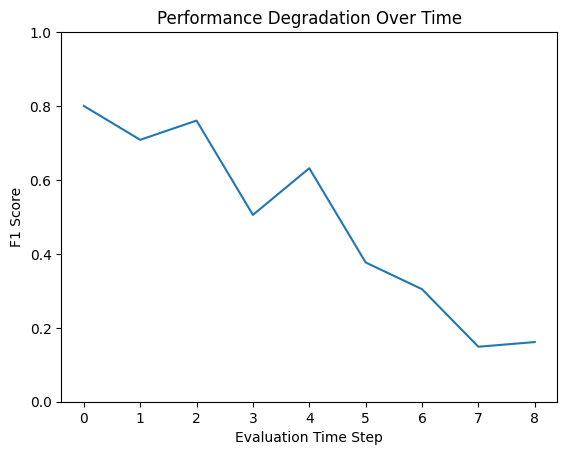

In [176]:
plt.plot(f1_list)
plt.title("Performance Degradation Over Time")
plt.ylim(0,1)
plt.ylabel("F1 Score")
plt.xlabel("Evaluation Time Step")
plt.show()